# **Exploratory data analysis: Feature set 1**

Prior to developing our models we need to analyse the time series data and carry out exploratory data analysis.

Patient time series (dynamic) data for select features in the last 6 hours prior to extubation have been extracted.

We now need to identify how much data is null/missing, how many patients we have and what features have been recorded. This informs us of what preprocessing is required - whether features need to be removed and how to fill missing data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load patient data for feature set 1
file_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/05_time_series_data_extraction/feature_set_1_results/full_data_feature_set_1/full_data_incl_null.parquet'
patient_data_f1_df = pd.read_parquet(file_path)
patient_data_f1_df.head()

subject_id           charttime    itemid  valuenum
0    10001884 2131-01-12 15:00:00  223835.0      40.0
1    10001884 2131-01-12 15:00:00  224685.0     284.0
2    10001884 2131-01-12 15:00:00  224686.0     284.0
3    10001884 2131-01-12 15:00:00  224687.0       6.1
4    10001884 2131-01-12 15:00:00  224695.0      17.0

In [ ]:
patient_data_f1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116639 entries, 0 to 116638
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   subject_id  116639 non-null  int64         
 1   charttime   116639 non-null  datetime64[ns]
 2   itemid      116639 non-null  float64       
 3   valuenum    116639 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 3.6 MB


In [ ]:
# Convert itemid to an integer
patient_data_f1_df['itemid'] = patient_data_f1_df['itemid'].astype('int64')
patient_data_f1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116639 entries, 0 to 116638
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   subject_id  116639 non-null  int64         
 1   charttime   116639 non-null  datetime64[ns]
 2   itemid      116639 non-null  int64         
 3   valuenum    116639 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.6 MB


In [ ]:
# Load labels for patients
label_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/05_time_series_data_extraction/feature_set_1_results/full_data_feature_set_1/full_labels_incl_null.parquet'
labels_df = pd.read_parquet(label_path)
labels_df.head()

subject_id  extubation_failure
0    10001884                   1
1    10001884                   1
2    10001884                   1
3    10001884                   1
4    10001884                   1

In [ ]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116639 entries, 0 to 116638
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   subject_id          116639 non-null  int64
 1   extubation_failure  116639 non-null  int64
dtypes: int64(2)
memory usage: 1.8 MB


**Number of patients**

First we can look at how many patients we have in this extracted set. Any patients not present from the orginial MIMIC set derived using the exclusion criteria will not have had any data for these features recorded in the last 6 hours prior to extubation.

In [ ]:
# Count the number of unique subject_ids / patients in this dataframe
print(f'Number of patients: {patient_data_f1_df["subject_id"].nunique()}')

Number of patients: 4701


In [ ]:
# Count the number of patients in the orginal extracted exclusion set
extraction_set = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/03_annotated_set/annotation_v03.parquet'
extraction_df = pd.read_parquet(extraction_set)
print(f'Number of patients in original set: {extraction_df["subject_id"].nunique()}')

Number of patients in original set: 5970


Compared to the original set of 5970 patients, only 4701 have data recorded for the select features in the last 6 hours prior to extubation. This possibly highlights the data disparity conventially seen in medical data.

**Extubation failure proportion**

In this new set of 4701 patients, we need to recompute the split between extubation failure and success.

In [ ]:
# For each unique patient in the labels file give the proportion that have extubation_failure = 1 and = 0
labels_unique = labels_df.drop_duplicates(subset=['subject_id'])
total_patients = len(labels_unique)
extubation_failure_count = labels_unique['extubation_failure'].sum()
failure_percentage = (extubation_failure_count / total_patients) * 100
print(f'Extubation failure proportion: {failure_percentage:.2f}%')

Extubation failure proportion: 32.84%


Let's compare this to the original extraction set.

In [ ]:
# Calculate the failure rate in the orignial extraction set
original_failure_count = extraction_df['extubation_failure'].sum()
original_failure_percentage = (original_failure_count / len(extraction_df)) * 100
print(f'Extubation failure proportion: {original_failure_percentage:.2f}%')

Extubation failure proportion: 32.01%


Despite the number of patients reducing, the failure proportion remains broadly the same.

**Patient spread over segments**

We can look at how the new group of patients is spread over our previously defined segments based on ventilation duration.

As recommended by Dr Murali, our patient dataset should be placed into clincially relevant segments as below:

- < 24 hours (generally post-operative) has already been removed
- 1 day to 7 days
- 8 days to 21 days
- more than 21 days

In [ ]:
# Load the list of patients from each segment
one_to_7_days_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/04_patient_segmentation/1_to_7_days.parquet'
eight_to_21_days_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/04_patient_segmentation/8_to_21_days.parquet'
more_than_21_days_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/04_patient_segmentation/more_than_21_days.parquet'

In [ ]:
# Load them into dataframes
one_to_7_days_df = pd.read_parquet(one_to_7_days_path)
eight_to_21_days_df = pd.read_parquet(eight_to_21_days_path)
more_than_21_days_df = pd.read_parquet(more_than_21_days_path)

one_to_7_days_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4961 entries, 0 to 26133
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   subject_id                     4961 non-null   int64         
 1   hadm_id                        4961 non-null   int64         
 2   stay_id                        4961 non-null   int64         
 3   ventilation_starttime          4961 non-null   datetime64[ns]
 4   ventilation_endtime            4961 non-null   datetime64[ns]
 5   ventilation_itemid             4961 non-null   int64         
 6   ventilation_ordercategoryname  4961 non-null   object        
 7   extubation_starttime           4961 non-null   datetime64[ns]
 8   extubation_endtime             4961 non-null   datetime64[ns]
 9   extubation_itemid              4961 non-null   int64         
 10  extubation_ordercategoryname   4961 non-null   object        
 11  ventilation_duration 

In [ ]:
# Allocate the list of patients from our extracted set to one of the dataframes and caluclate the percentage in each segment
one_to_7_days_df['segment'] = '1 to 7 days'
eight_to_21_days_df['segment'] = '8 to 21 days'
more_than_21_days_df['segment'] = 'more than 21 days'

all_segments_df = pd.concat([one_to_7_days_df, eight_to_21_days_df, more_than_21_days_df])

df_unique_segments = pd.merge(labels_unique, all_segments_df[['subject_id', 'segment']], on='subject_id', how='left')

segment_counts = df_unique_segments['segment'].value_counts(normalize=True) * 100
print(segment_counts)

segment
1 to 7 days          86.261062
8 to 21 days         13.451327
more than 21 days     0.287611
Name: proportion, dtype: float64


The majority of patients are, as previously, in the 1 to 7 days segment so the distribution of patients has not been greatly affected.

# **Feature analysis**

We now need to look at any inferences we can derive from the feature data itself.

**01 - Feature identification**

First, lets confirm what features we have in the data.

In [ ]:
# Load the d_items data frame
d_items_file = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/mimic-iv-2.2-raw-data/icu/d_items.csv'
d_items_df = pd.read_csv(d_items_file)
d_items_df.head()

itemid                    label        abbreviation         linksto  \
0  220001             Problem List        Problem List     chartevents   
1  220003       ICU Admission date  ICU Admission date  datetimeevents   
2  220045               Heart Rate                  HR     chartevents   
3  220046  Heart rate Alarm - High     HR Alarm - High     chartevents   
4  220047   Heart Rate Alarm - Low      HR Alarm - Low     chartevents   

              category unitname     param_type  lownormalvalue  \
0              General      NaN           Text             NaN   
1                  ADT      NaN  Date and time             NaN   
2  Routine Vital Signs      bpm        Numeric             NaN   
3               Alarms      bpm        Numeric             NaN   
4               Alarms      bpm        Numeric             NaN   

   highnormalvalue  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [ ]:
d_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4014 entries, 0 to 4013
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemid           4014 non-null   int64  
 1   label            4014 non-null   object 
 2   abbreviation     4014 non-null   object 
 3   linksto          4014 non-null   object 
 4   category         4014 non-null   object 
 5   unitname         1108 non-null   object 
 6   param_type       4014 non-null   object 
 7   lownormalvalue   19 non-null     float64
 8   highnormalvalue  22 non-null     float64
dtypes: float64(2), int64(1), object(6)
memory usage: 282.4+ KB


In [ ]:
# Print out the corresponding label for the unique itemids in the patient data
for itemid in patient_data_f1_df['itemid'].unique():
    label = d_items_df[d_items_df['itemid'] == itemid]['label'].values[0]
    print(f"{itemid}: {label}")

223835: Inspired O2 Fraction
224685: Tidal Volume (observed)
224686: Tidal Volume (spontaneous)
224687: Minute Volume
224695: Peak Insp. Pressure
228640: EtCO2
220210: Respiratory Rate
220277: O2 saturation pulseoxymetry
223849: Ventilator Mode
220224: Arterial O2 pressure
220235: Arterial CO2 Pressure
223830: PH (Arterial)
220228: Hemoglobin
224696: Plateau Pressure
224419: Negative Insp. Force


All features defined in feature set 1 have been extracted here.

**Addendum - Data reformatting for analysis**

First the charttime column needs to be reformatted to represent the hours to extubation, rather than the raw datetime.

Currently each patient will have data recorded at different times and dates and this will not be comparable.

We can create a new column of 'time_to_extubation' based on the extubation_starttime for each patient to create a consistent temporal format across all patients.



In [ ]:
# Load the full patient list with extubation_starttimes
all_patients = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/03_annotated_set/annotation_v03.parquet'
all_patients_df = pd.read_parquet(all_patients)
all_patients_df.head()

subject_id   hadm_id   stay_id ventilation_starttime ventilation_endtime  \
0     10001884  26184834  37510196   2131-01-11 04:40:00 2131-01-12 17:40:00   
22    10002428  28662225  38875437   2156-04-19 20:10:00 2156-04-22 17:05:00   
29    10004235  24181354  34100191   2196-02-24 16:52:00 2196-02-27 16:28:00   
32    10004720  22081550  35009126   2186-11-12 20:29:00 2186-11-17 14:00:00   
33    10004733  27411876  39635619   2174-12-04 12:25:00 2174-12-07 16:20:00   

    ventilation_itemid ventilation_ordercategoryname extubation_starttime  \
0               225792                   Ventilation  2131-01-12 17:40:00   
22              225792                   Ventilation  2156-04-22 17:10:00   
29              225792                   Ventilation  2196-02-27 16:28:00   
32              225792                   Ventilation  2186-11-17 14:00:00   
33              225792                   Ventilation  2174-12-07 16:20:00   

    extubation_endtime  extubation_itemid extubation_ordercategoryname  \
0  2131-01-12 17:41:00             227194        Intubation/Extubation   
22 2156-04-22 17:11:00             227194        Intubation/Extubation   
29 2196-02-27 16:29:00             227194        Intubation/Extubation   
32 2186-11-17 14:01:00             227194        Intubation/Extubation   
33 2174-12-07 16:21:00             227194        Intubation/Extubation   

    ventilation_duration  anchor_age  extubation_failure  
0                 2220.0          68                   1  
22                4135.0          80                   0  
29                4296.0          47                   1  
32                6811.0          61                   1  
33                4555.0          51                   0

In [ ]:
# Extract only subject_id and extubation_starttime
all_patients_df = all_patients_df[['subject_id', 'extubation_starttime']]
all_patients_df.head()

subject_id extubation_starttime
0     10001884  2131-01-12 17:40:00
22    10002428  2156-04-22 17:10:00
29    10004235  2196-02-27 16:28:00
32    10004720  2186-11-17 14:00:00
33    10004733  2174-12-07 16:20:00

In [ ]:
# Create a new column in the extracted patient set of time_to_extubation and calculate based on extubation_starttime in all_patients, matched to subejct_id
patient_data_f1_merged_df = pd.merge(patient_data_f1_df, all_patients_df, on='subject_id', how='left')
patient_data_f1_merged_df['time_to_extubation_mins'] = (patient_data_f1_merged_df['extubation_starttime'] - patient_data_f1_merged_df['charttime']) / np.timedelta64(1, 'm')
patient_data_f1_merged_df.head()

subject_id           charttime  itemid  valuenum extubation_starttime  \
0    10001884 2131-01-12 15:00:00  223835      40.0  2131-01-12 17:40:00   
1    10001884 2131-01-12 15:00:00  224685     284.0  2131-01-12 17:40:00   
2    10001884 2131-01-12 15:00:00  224686     284.0  2131-01-12 17:40:00   
3    10001884 2131-01-12 15:00:00  224687       6.1  2131-01-12 17:40:00   
4    10001884 2131-01-12 15:00:00  224695      17.0  2131-01-12 17:40:00   

   time_to_extubation_mins  
0                    160.0  
1                    160.0  
2                    160.0  
3                    160.0  
4                    160.0

In [ ]:
# Create an additional column for ascending chronological order of charttime within the 6 hour window called 'time_from_window_start'
patient_data_f1_merged_df['time_from_window_start_mins'] = (6 * 60) - patient_data_f1_merged_df['time_to_extubation_mins']
patient_data_f1_merged_df.head()


subject_id  itemid  valuenum  time_to_extubation_mins  \
0    10001884  223835      40.0                    160.0   
1    10001884  224685     284.0                    160.0   
2    10001884  224686     284.0                    160.0   
3    10001884  224687       6.1                    160.0   
4    10001884  224695      17.0                    160.0   

   time_from_window_start  time_from_window_start_mins  
0                   200.0                        200.0  
1                   200.0                        200.0  
2                   200.0                        200.0  
3                   200.0                        200.0  
4                   200.0                        200.0

In [ ]:
# Drop time_from_window_start
patient_data_f1_merged_df = patient_data_f1_merged_df.drop(columns=['time_from_window_start_mins'])
patient_data_f1_merged_df.head()


subject_id  itemid  valuenum  time_to_extubation_mins  \
0    10001884  223835      40.0                    160.0   
1    10001884  224685     284.0                    160.0   
2    10001884  224686     284.0                    160.0   
3    10001884  224687       6.1                    160.0   
4    10001884  224695      17.0                    160.0   

   time_from_window_start  
0                   200.0  
1                   200.0  
2                   200.0  
3                   200.0  
4                   200.0

In [ ]:
# Save this data frame for later use as parquet file
patient_data_f1_merged_df.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/06_extracted_data_analysis/01_feature_set_1_analysis/patient_f1_data.parquet')

In [ ]:
patient_f1_data_reformatted_df = patient_data_f1_merged_df
patient_f1_data_reformatted_df.head()

subject_id  itemid  valuenum  time_to_extubation_mins  \
0    10001884  223835      40.0                    160.0   
1    10001884  224685     284.0                    160.0   
2    10001884  224686     284.0                    160.0   
3    10001884  224687       6.1                    160.0   
4    10001884  224695      17.0                    160.0   

   time_from_window_start  
0                   200.0  
1                   200.0  
2                   200.0  
3                   200.0  
4                   200.0

**02 - Missing data analysis**

It is important to understand what data is missing for each feature to then be able to impute correctly.

We will first look at missing data generally and then look more closely at each feature.

In [ ]:
patient_f1_data_reformatted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116639 entries, 0 to 116638
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   subject_id               116639 non-null  int64  
 1   itemid                   116639 non-null  int64  
 2   valuenum                 116639 non-null  float64
 3   time_to_extubation_mins  116639 non-null  float64
 4   time_from_window_start   116639 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 4.4 MB


Null values per itemid to see if specific itemids are missing a lot of values.

In [ ]:
# Check for null values in the 'valuenum' column
# For each itemid count the number of null values
null_counts = patient_f1_data_reformatted_df.groupby('itemid')['valuenum'].apply(lambda x: x.isnull().sum()).reset_index()
null_counts.columns = ['itemid', 'null_count']
null_counts

itemid  null_count
0   220210           0
1   220224           0
2   220228           0
3   220235           0
4   220277           0
5   223830           0
6   223835           0
7   223849           0
8   224419           0
9   224685           0
10  224686           0
11  224687           0
12  224695           0
13  224696           0
14  228640           0

There are no null values within the measurements that have been recorded.

**03 - Sampling frequency within the 6 hour time period for each feature**

As we will be training models that can read time series data, we will need to know how often each feature is sampled to then know how to resample it when pre-processing.

In [ ]:
# Count the sampling frequency of each feature
sampling_frequency = patient_f1_data_reformatted_df.groupby(['itemid', 'time_from_window_start']).size().reset_index()
sampling_frequency.columns = ['itemid', 'time_from_window_start', 'count']
sampling_frequency.head()

itemid  time_from_window_start  count
0  220210                     0.0    461
1  220210                     1.0     54
2  220210                     2.0     68
3  220210                     3.0     44
4  220210                     4.0     47

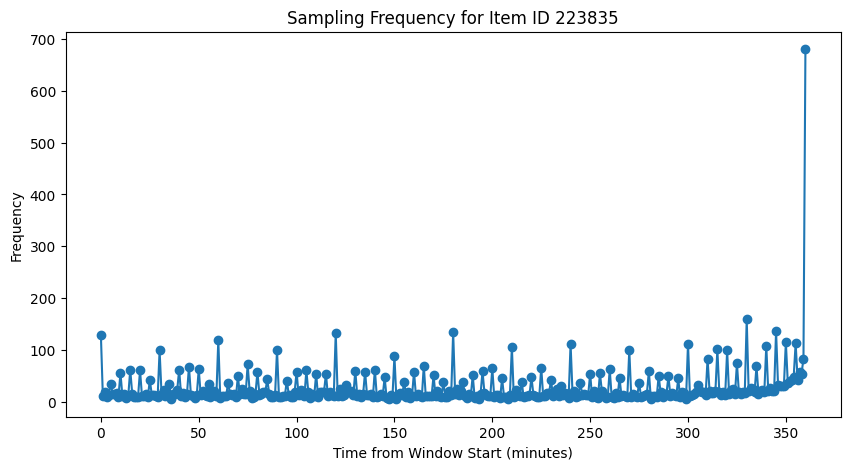

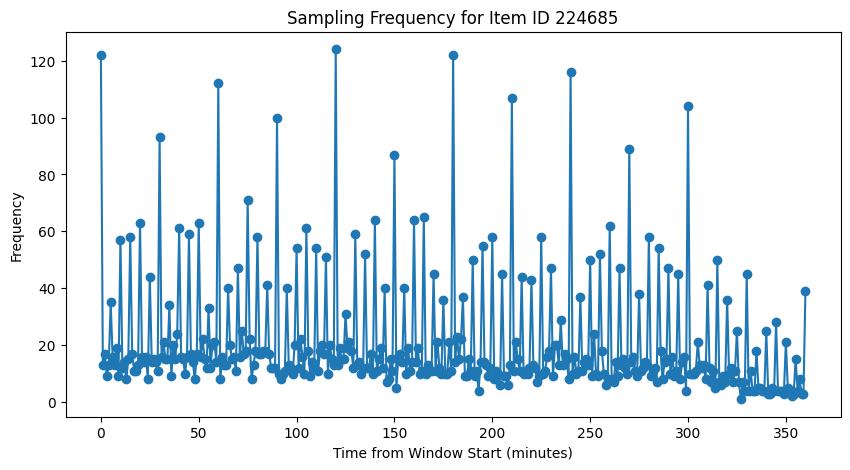

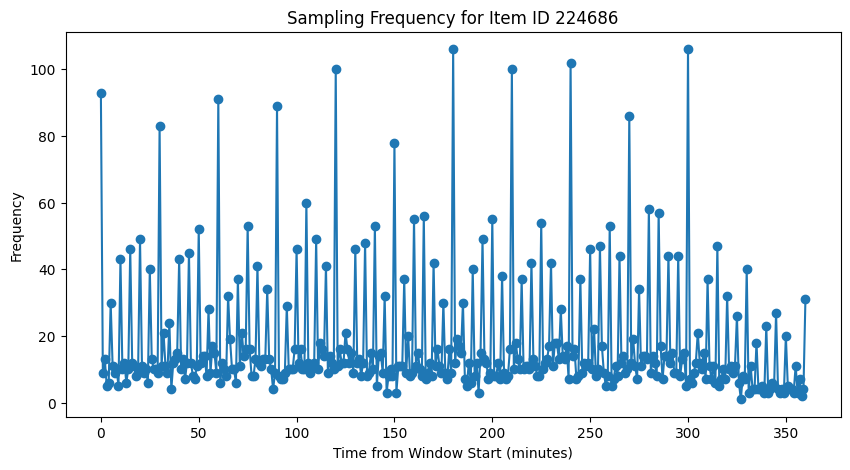

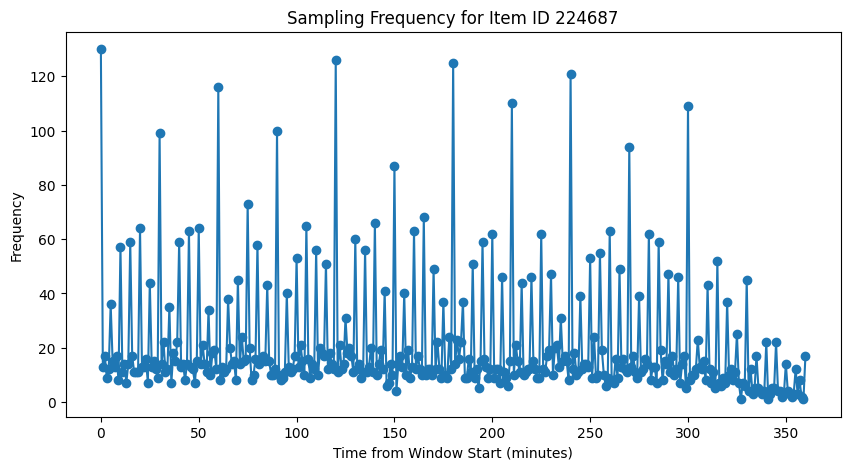

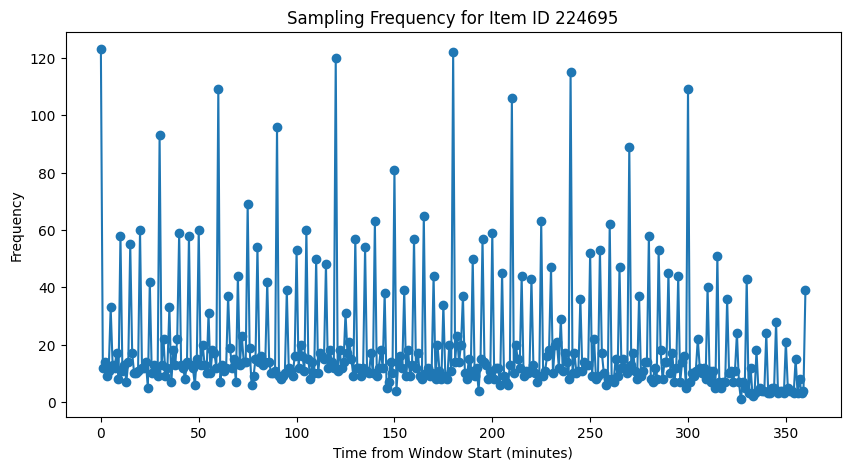

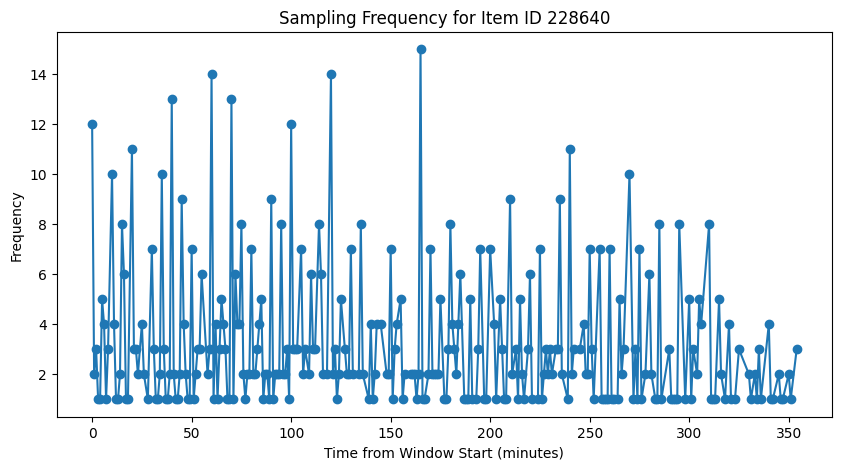

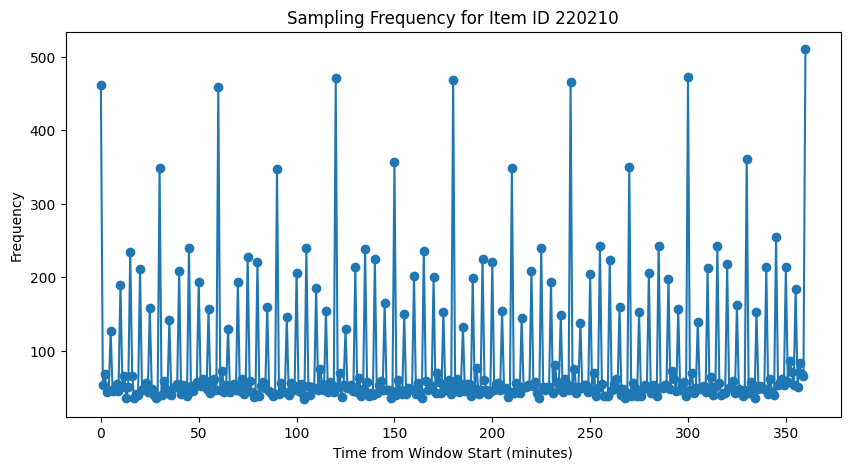

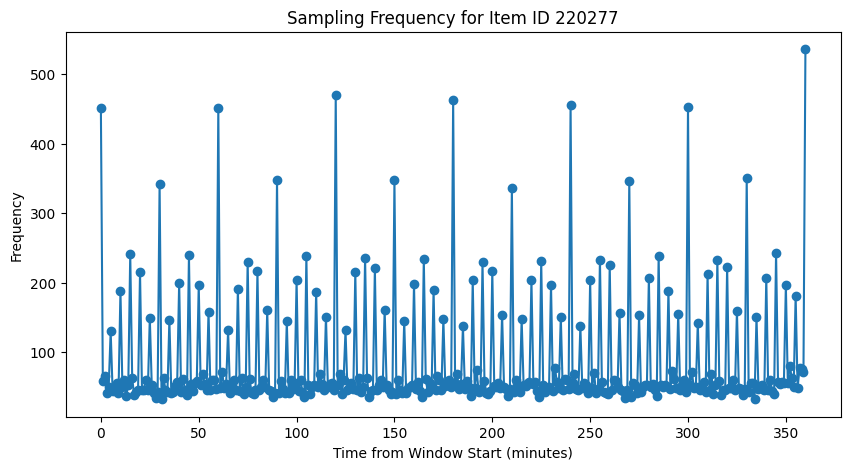

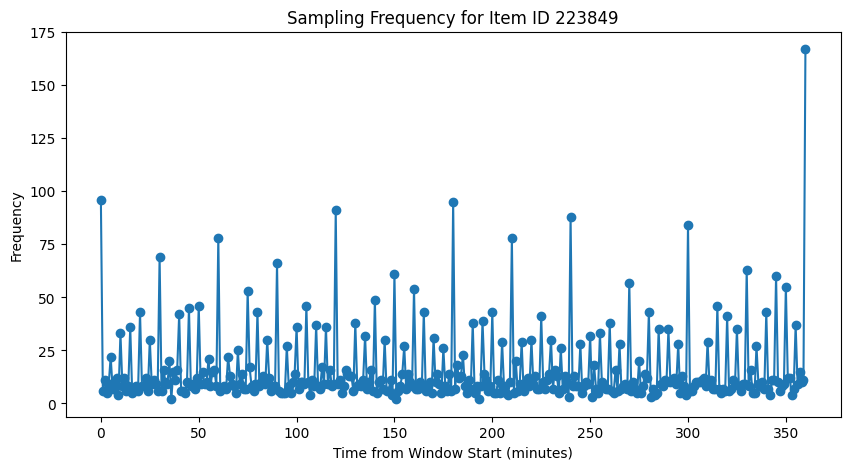

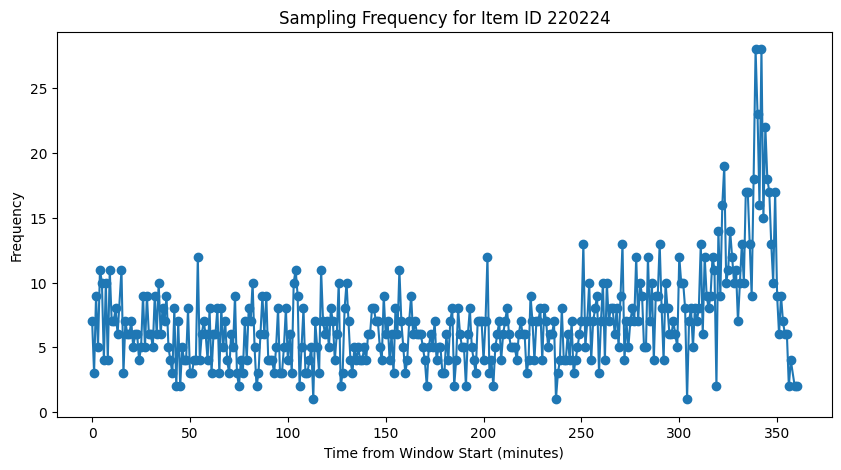

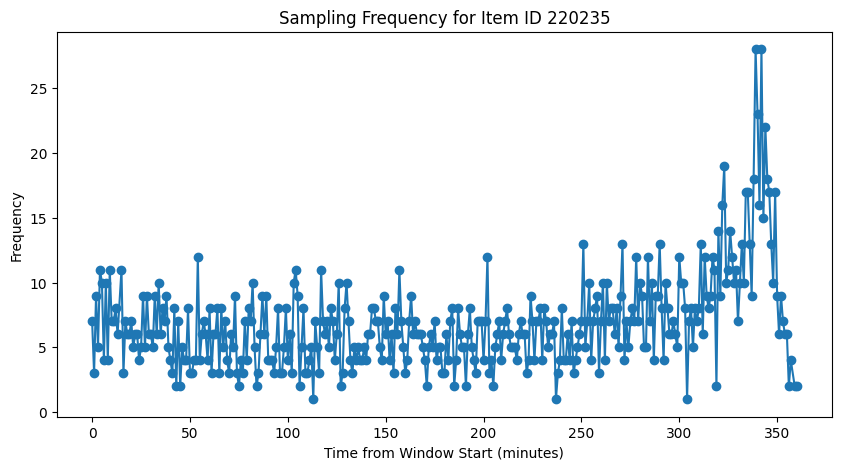

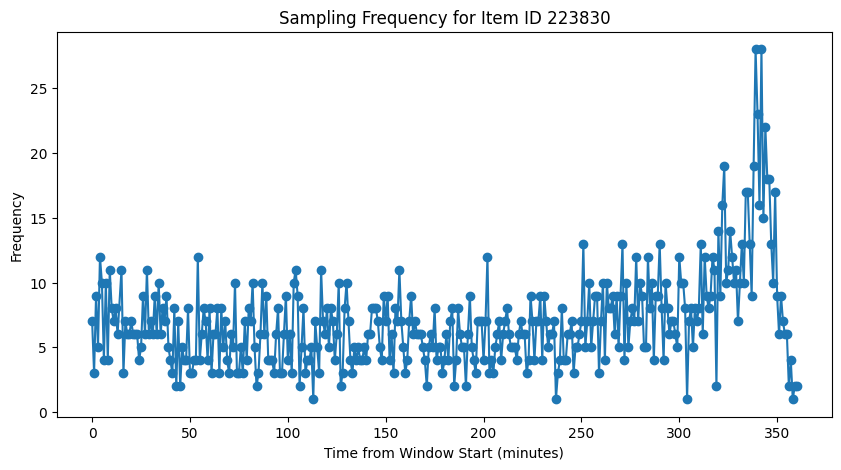

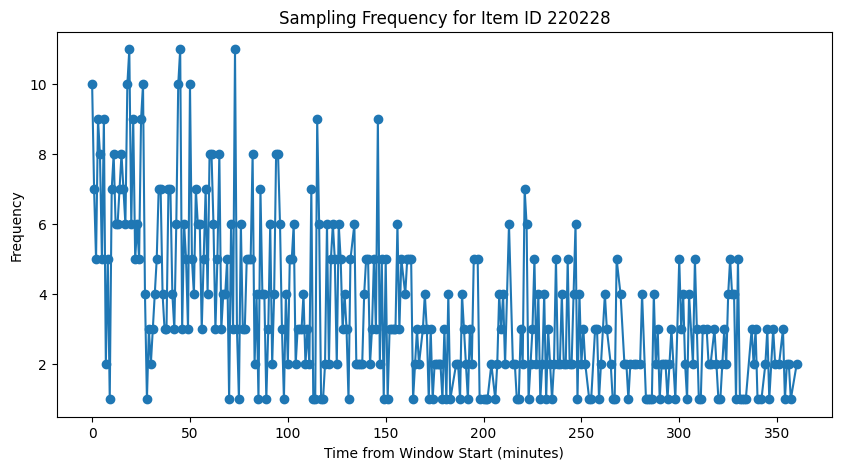

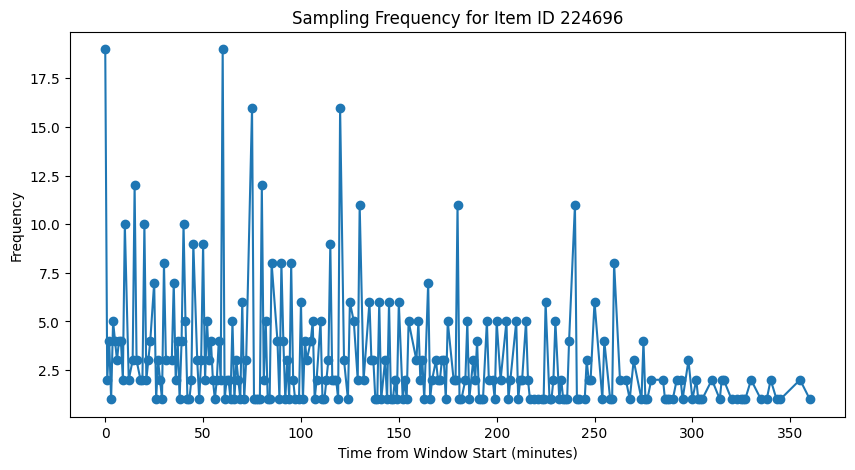

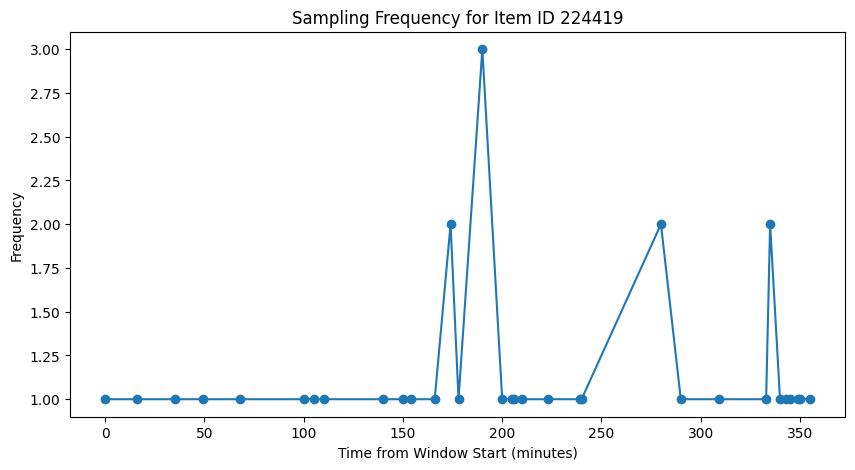

In [ ]:
# Plot the sampling frequency for each itemid
for item in patient_f1_data_reformatted_df['itemid'].unique():
    item_data = sampling_frequency[sampling_frequency['itemid'] == item]
    plt.figure(figsize=(10, 5))
    plt.plot(item_data['time_from_window_start'], item_data['count'], marker='o')
    plt.title(f'Sampling Frequency for Item ID {item}')
    plt.xlabel('Time from Window Start (minutes)')
    plt.ylabel('Frequency')
    plt.show()

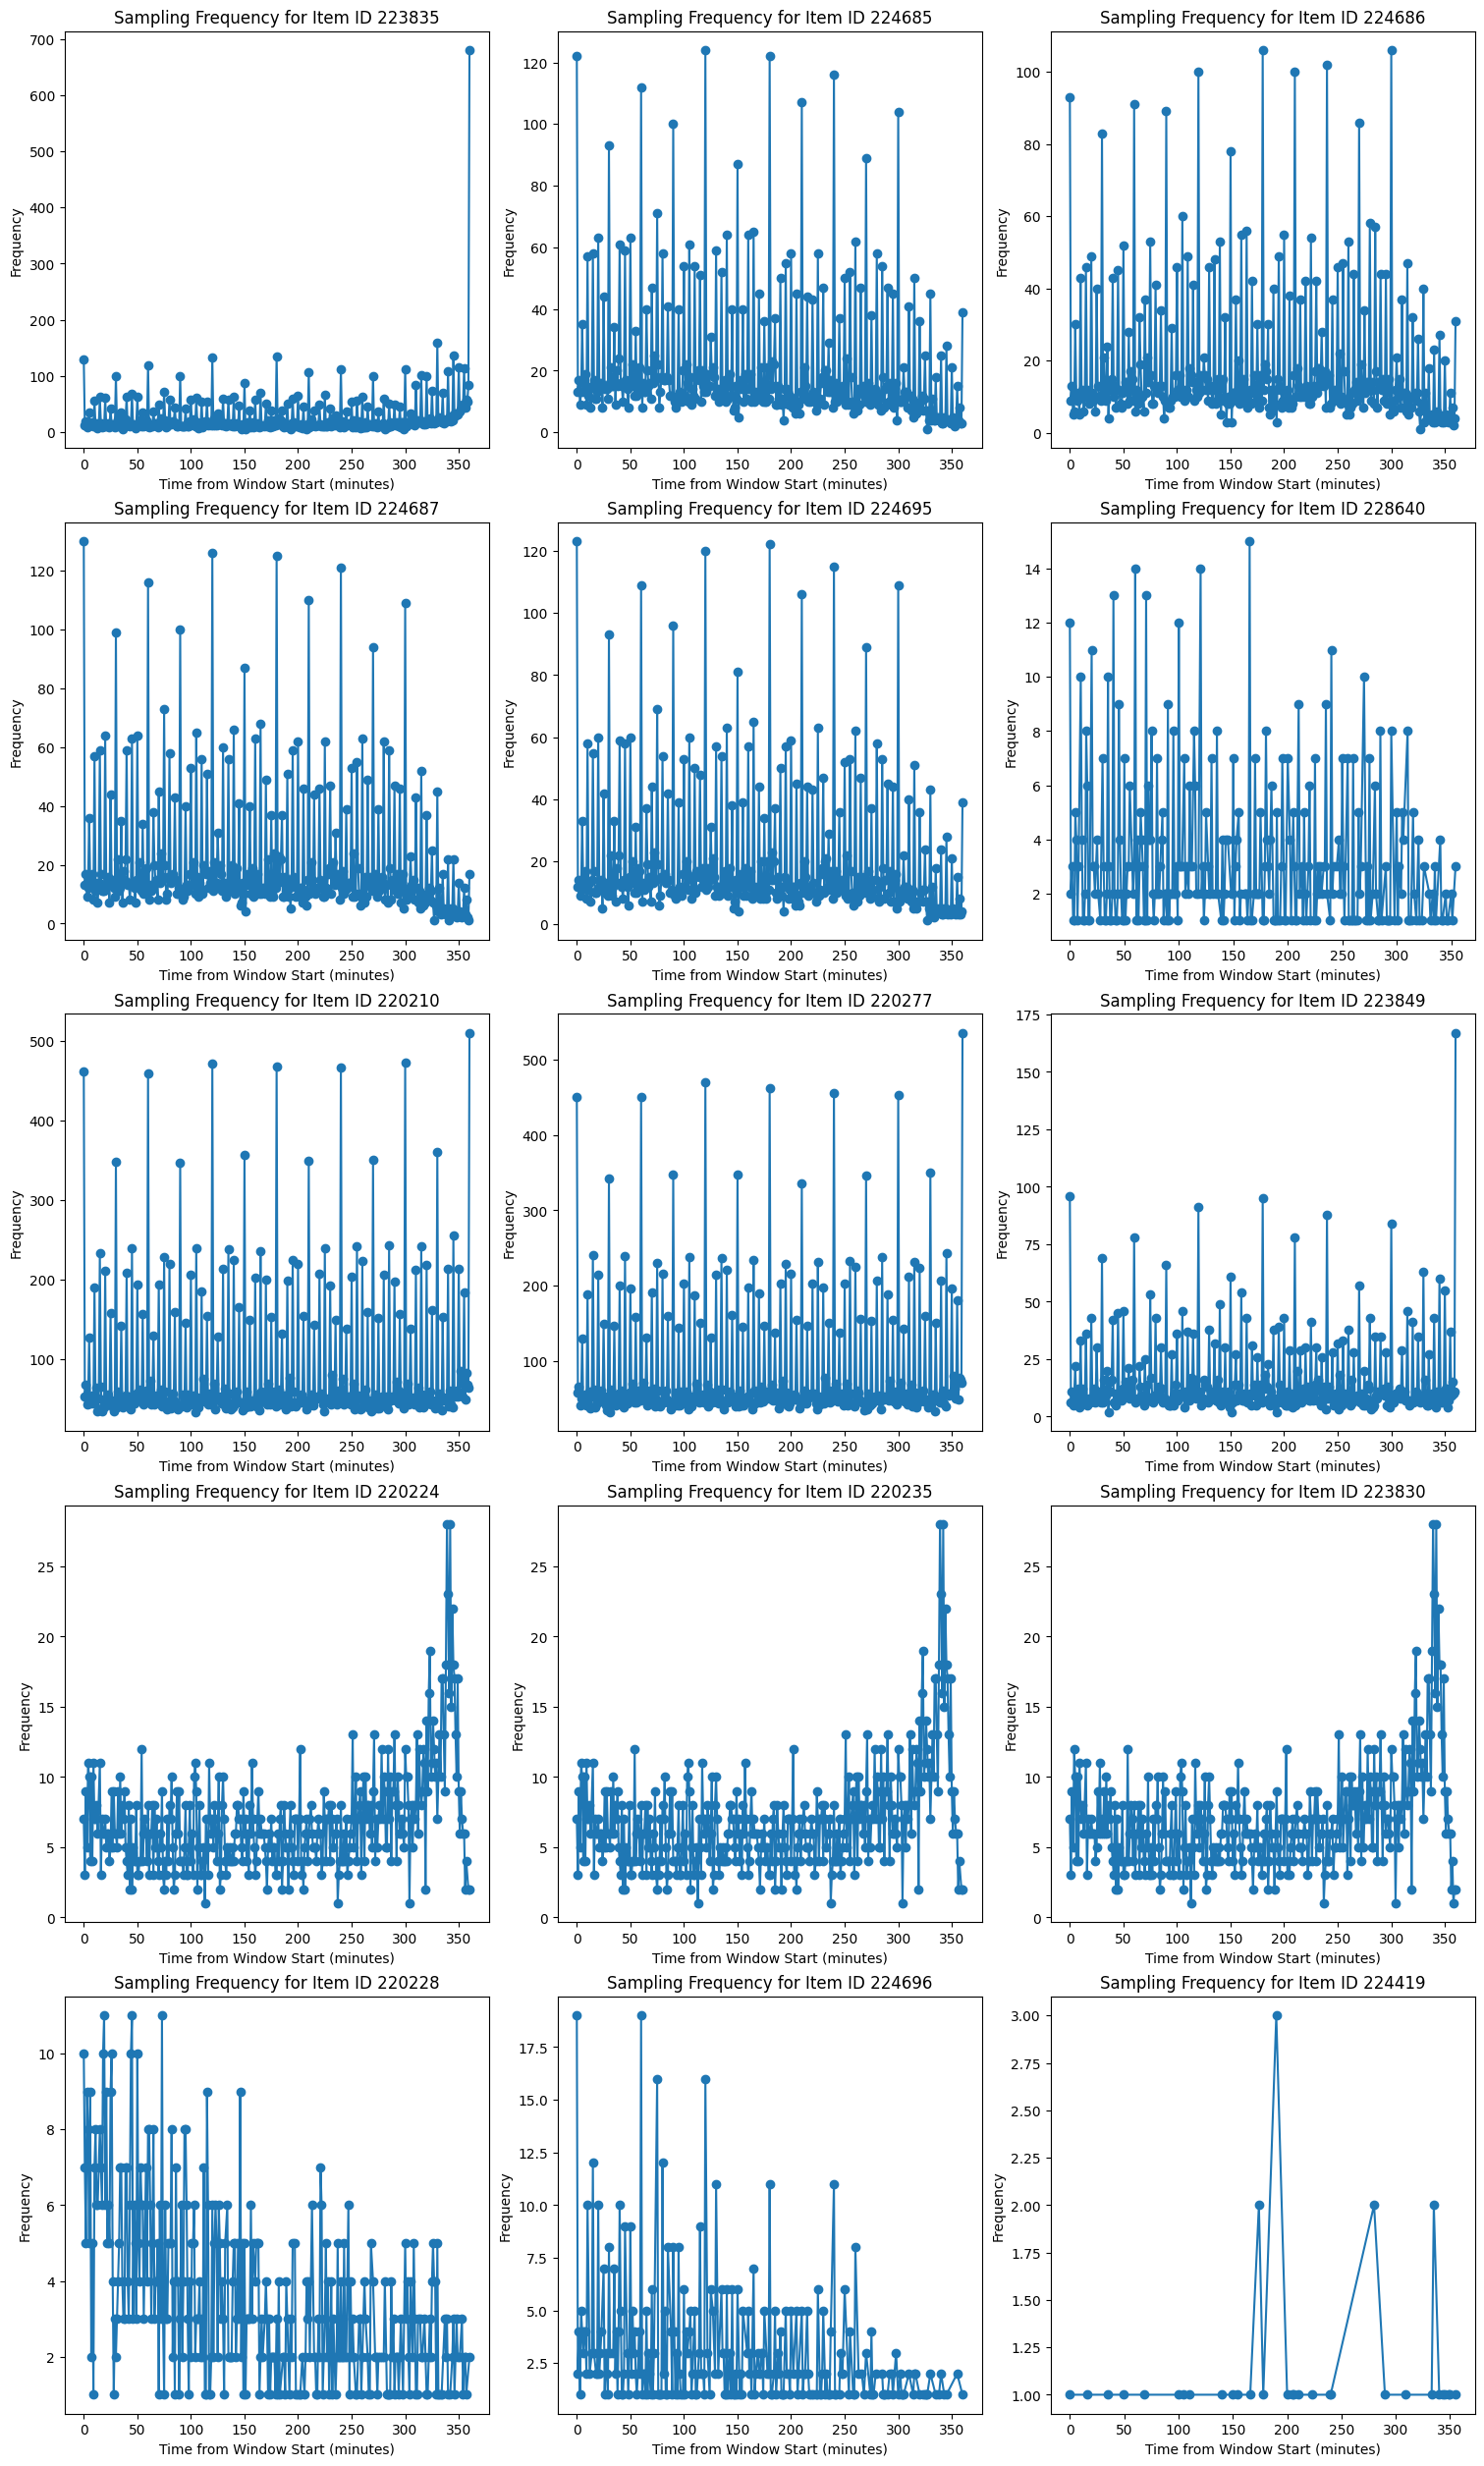

In [ ]:
# Determine the number of rows and columns for the subplots grid
num_features = patient_f1_data_reformatted_df['itemid'].nunique()
num_cols = 3  # You can adjust this to fit your layout preferences
num_rows = (num_features + num_cols - 1) // num_cols

# Create the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5), constrained_layout=True)

# Plot each feature in a separate subplot
for idx, item in enumerate(patient_f1_data_reformatted_df['itemid'].unique()):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    item_data = sampling_frequency[sampling_frequency['itemid'] == item]
    ax.plot(item_data['time_from_window_start'], item_data['count'], marker='o')
    ax.set_title(f'Sampling Frequency for Item ID {item}')
    ax.set_xlabel('Time from Window Start (minutes)')
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for idx in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[idx])

# Show the plot
plt.show()

Including labels of the features for clarity.

In [ ]:
features_with_labels_df = pd.merge(patient_f1_data_reformatted_df, d_items_df[['itemid', 'label']], on='itemid', how='left')

# Group by label and time_from_window_start to count the number of samples
sampling_frequency = features_with_labels_df.groupby(['label', 'time_from_window_start']).size().reset_index(name='count')

sampling_frequency.head()

label  time_from_window_start  count
0  Arterial CO2 Pressure                     0.0      7
1  Arterial CO2 Pressure                     1.0      3
2  Arterial CO2 Pressure                     2.0      9
3  Arterial CO2 Pressure                     3.0      5
4  Arterial CO2 Pressure                     4.0     11

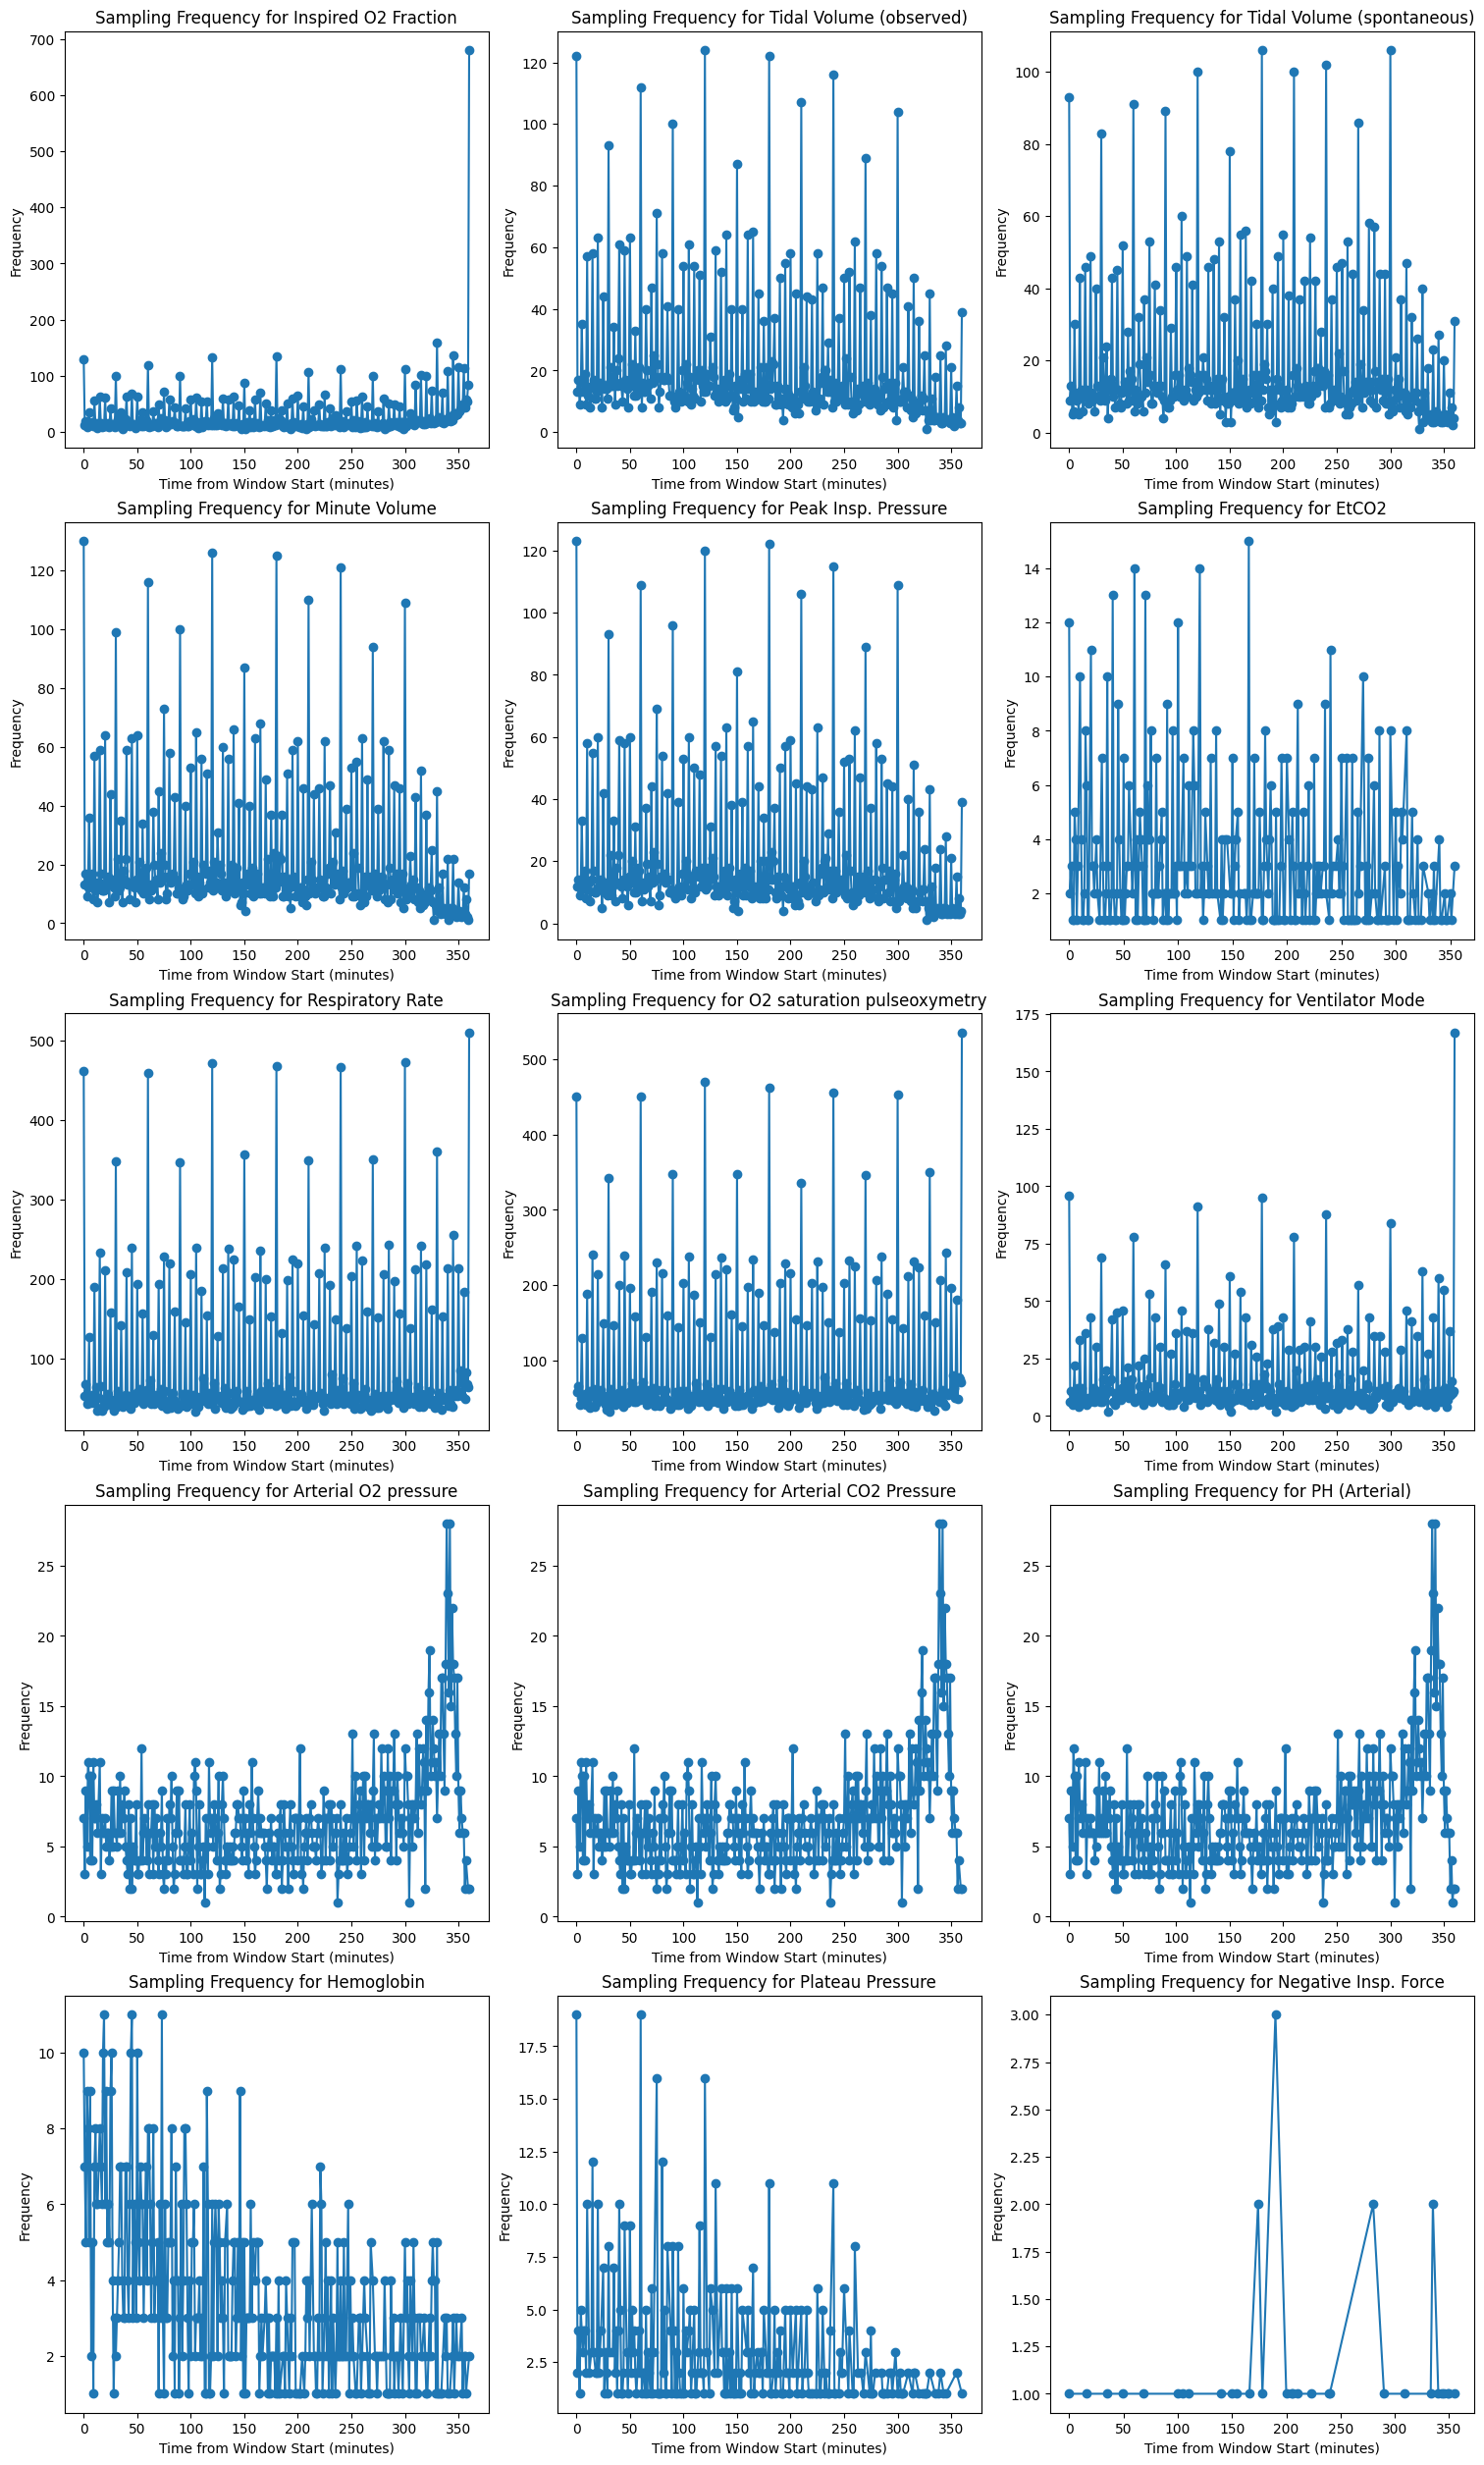

In [ ]:
# Determine the number of rows and columns for the subplots grid
num_features = features_with_labels_df['label'].nunique()
num_cols = 3  # You can adjust this to fit your layout preferences
num_rows = (num_features + num_cols - 1) // num_cols

# Create the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5), constrained_layout=True)

# Plot each feature in a separate subplot
for idx, label in enumerate(features_with_labels_df['label'].unique()):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    item_data = sampling_frequency[sampling_frequency['label'] == label]
    ax.plot(item_data['time_from_window_start'], item_data['count'], marker='o')
    ax.set_title(f'Sampling Frequency for {label}')
    ax.set_xlabel('Time from Window Start (minutes)')
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for idx in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[idx])

# Show the plot
plt.show()

It seems all features have varying levels of observation and sampling frequency.

It is clear, however, that some features are sampled significantly more frequently than others.

The next plot will order features by their overall observation/sampling level.

In [ ]:
# Calculate the total number of observations per label
total_observations = features_with_labels_df['label'].value_counts().reset_index()
total_observations.columns = ['label', 'total_count']
# Display the total observations
total_observations

label  total_count
0              Respiratory Rate        31096
1   O2 saturation pulseoxymetry        31076
2          Inspired O2 Fraction         9893
3       Tidal Volume (observed)         7523
4                 Minute Volume         7510
5           Peak Insp. Pressure         7165
6    Tidal Volume (spontaneous)         6429
7               Ventilator Mode         5660
8                 PH (Arterial)         2513
9          Arterial O2 pressure         2467
10        Arterial CO2 Pressure         2467
11                   Hemoglobin         1162
12                        EtCO2          889
13             Plateau Pressure          751
14         Negative Insp. Force           38

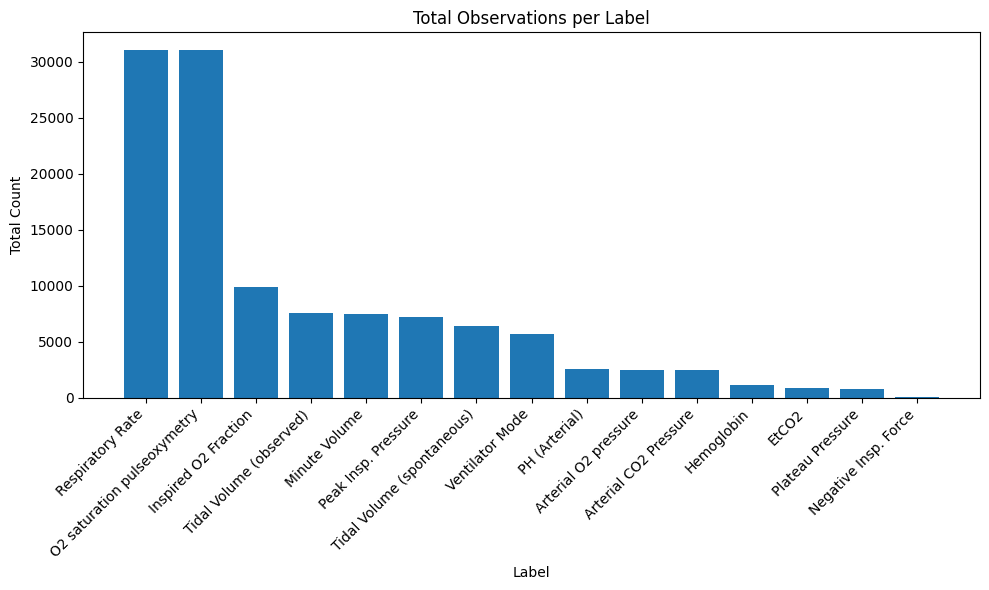

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(total_observations['label'], total_observations['total_count'])
plt.xlabel('Label')
plt.ylabel('Total Count')
plt.title('Total Observations per Label')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

As you can see, Respiratory Rate and SaO2 are sampled the most. On the other hand, Maximum Inspiratory Pressure (Negative Insp. Force) is barely sampled.

When pre-processing we will need to take this into consideration as while imputation is possible, a sufficient amount of data is required to be able to make sensible imputations.

**04 - Sampling frequency per patient**

As the data will need to be on a per patient basis to make a prediction, it is important to know how often for each patient, each feature is sampled.

If there are features that are rarely recorded across the patient population then a decision needs to be made as to whether to exclude these from the model input data.

In [ ]:
# Group by subject_id and itemid to count the number of samples for each combination
per_patient_sampling_frequency = features_with_labels_df.groupby(['subject_id', 'label']).size().reset_index(name='count')
per_patient_sampling_frequency.head()

subject_id                        label  count
0    10001884                        EtCO2      1
1    10001884         Inspired O2 Fraction      1
2    10001884                Minute Volume      1
3    10001884  O2 saturation pulseoxymetry     12
4    10001884          Peak Insp. Pressure      1

In [ ]:
# Using dataframe per_patient_sampling_frequency: pivot to have subject id as rows

per_patient_sampling_frequency_pivot = per_patient_sampling_frequency.pivot(index='subject_id', columns='label', values='count').fillna(0)
per_patient_sampling_frequency_pivot

label       Arterial CO2 Pressure  Arterial O2 pressure  EtCO2  Hemoglobin  \
subject_id                                                                   
10001884                      0.0                   0.0    1.0         0.0   
10002428                      1.0                   1.0    0.0         0.0   
10004235                      2.0                   2.0    0.0         1.0   
10004720                      0.0                   0.0    0.0         0.0   
10004733                      0.0                   0.0    0.0         0.0   
...                           ...                   ...    ...         ...   
17912822                      2.0                   2.0    0.0         0.0   
17914007                      2.0                   2.0    0.0         0.0   
17920350                      0.0                   0.0    0.0         0.0   
17921701                      1.0                   1.0    0.0         0.0   
17923146                      0.0                   0.0    0.0         0.0   

label       Inspired O2 Fraction  Minute Volume  Negative Insp. Force  \
subject_id                                                              
10001884                     1.0            1.0                   0.0   
10002428                     4.0            4.0                   0.0   
10004235                     2.0            1.0                   0.0   
10004720                     2.0            2.0                   0.0   
10004733                     1.0            1.0                   0.0   
...                          ...            ...                   ...   
17912822                     3.0            2.0                   0.0   
17914007                     1.0            1.0                   0.0   
17920350                     2.0            1.0                   0.0   
17921701                     1.0            1.0                   0.0   
17923146                     2.0            1.0                   0.0   

label       O2 saturation pulseoxymetry  PH (Arterial)  Peak Insp. Pressure  \
subject_id                                                                    
10001884                           12.0            0.0                  1.0   
10002428                            6.0            1.0                  2.0   
10004235                            6.0            2.0                  1.0   
10004720                            7.0            0.0                  2.0   
10004733                           12.0            0.0                  1.0   
...                                 ...            ...                  ...   
17912822                            6.0            2.0                  1.0   
17914007                            6.0            2.0                  1.0   
17920350                            6.0            0.0                  1.0   
17921701                            6.0            1.0                  1.0   
17923146                            4.0            0.0                  1.0   

label       Plateau Pressure  Respiratory Rate  Tidal Volume (observed)  \
subject_id                                                                
10001884                 0.0              12.0                      1.0   
10002428                 0.0               6.0                      4.0   
10004235                 0.0               6.0                      0.0   
10004720                 0.0               7.0                      2.0   
10004733                 0.0              12.0                      1.0   
...                      ...               ...                      ...   
17912822                 1.0               6.0                      2.0   
17914007                 0.0               6.0                      1.0   
17920350                 0.0               6.0                      1.0   
17921701                 0.0               6.0                      1.0   
17923146                 0.0               4.0                      1.0   

label       Tidal Volume (spont

In [ ]:
# Export this table as a csv file and save file in drive
per_patient_sampling_frequency_pivot.to_csv('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/notebooks/03_data_preprocessing/02_data_preprocessing/01_feature_set_1/per_patient_sampling_frequency.csv', index=True)

Let's visualise this with some plots.

In [ ]:
# Calculate the average sampling frequency per feature

average_sampling_frequency = per_patient_sampling_frequency_pivot.mean().sort_values(ascending=False)

# Create columns for the table
average_sampling_frequency_df = pd.DataFrame({'Feature': average_sampling_frequency.index, 'Average Sampling Frequency': average_sampling_frequency.values})

# Display the table
average_sampling_frequency_df

Feature  Average Sampling Frequency
0              Respiratory Rate                    6.614763
1   O2 saturation pulseoxymetry                    6.610508
2          Inspired O2 Fraction                    2.104446
3       Tidal Volume (observed)                    1.600298
4                 Minute Volume                    1.597532
5           Peak Insp. Pressure                    1.524144
6    Tidal Volume (spontaneous)                    1.367581
7               Ventilator Mode                    1.203999
8                 PH (Arterial)                    0.534567
9         Arterial CO2 Pressure                    0.524782
10         Arterial O2 pressure                    0.524782
11                   Hemoglobin                    0.247181
12                        EtCO2                    0.189109
13             Plateau Pressure                    0.159753
14         Negative Insp. Force                    0.008083

In [ ]:
# Save this average sampling frequency table for later use
average_sampling_frequency_df.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/06_extracted_data_analysis/01_feature_set_1_analysis/sampling_frequency.parquet')

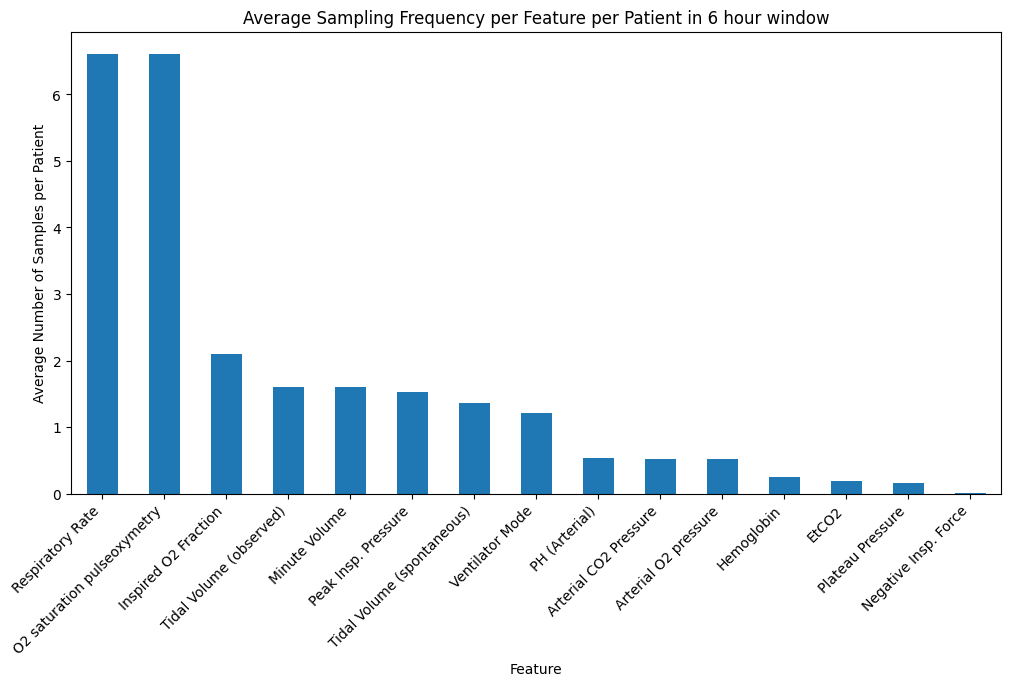

In [ ]:
# Plot the average sampling frequency
plt.figure(figsize=(12, 6))
average_sampling_frequency.plot(kind='bar')
plt.title('Average Sampling Frequency per Feature per Patient in 6 hour window')
plt.xlabel('Feature')
plt.ylabel('Average Number of Samples per Patient')
plt.xticks(rotation=45, ha='right')
plt.show()

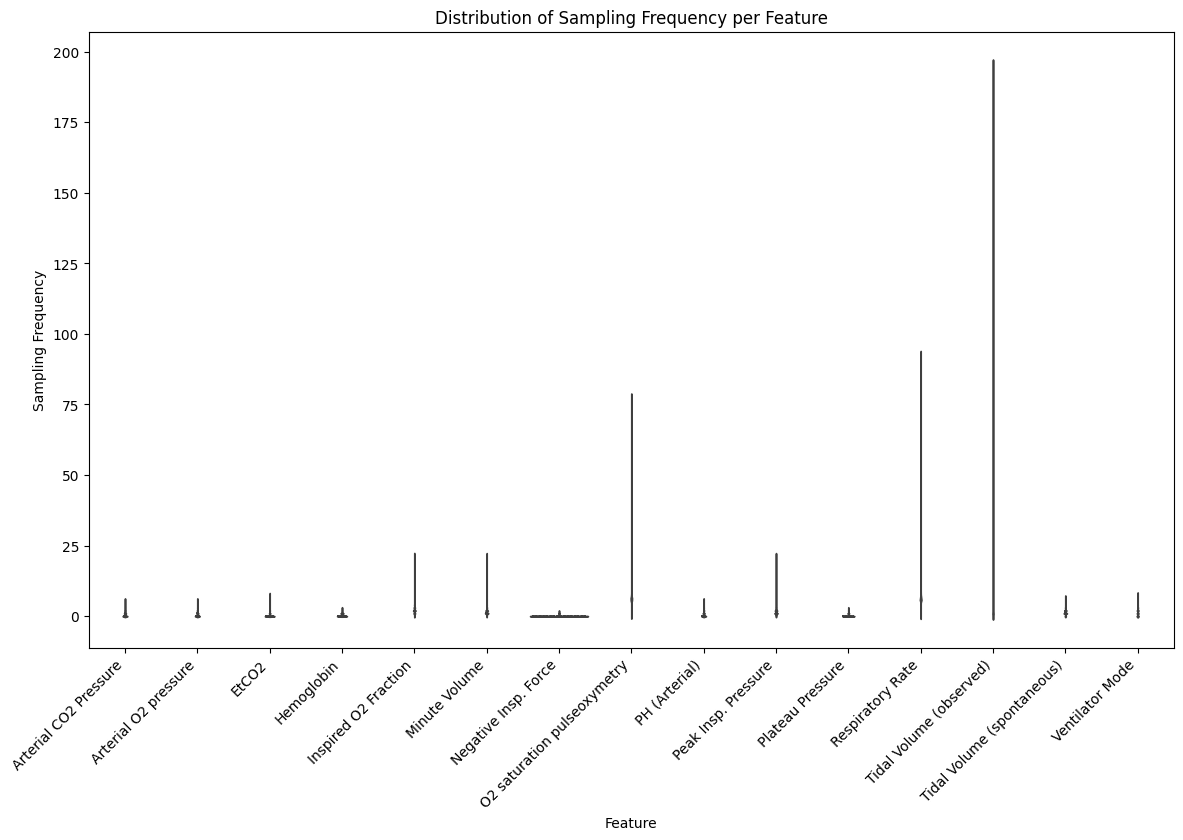

In [ ]:
# Melt the pivoted DataFrame for easier plotting with seaborn
sampling_frequency_melted = per_patient_sampling_frequency_pivot.reset_index().melt(id_vars=['subject_id'], var_name='Feature', value_name='Frequency')

# Plot the distribution of sampling frequencies using a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='Feature', y='Frequency', data=sampling_frequency_melted, inner='quartile')
plt.title('Distribution of Sampling Frequency per Feature')
plt.xlabel('Feature')
plt.ylabel('Sampling Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


That is not very useful so we will try a heatmap

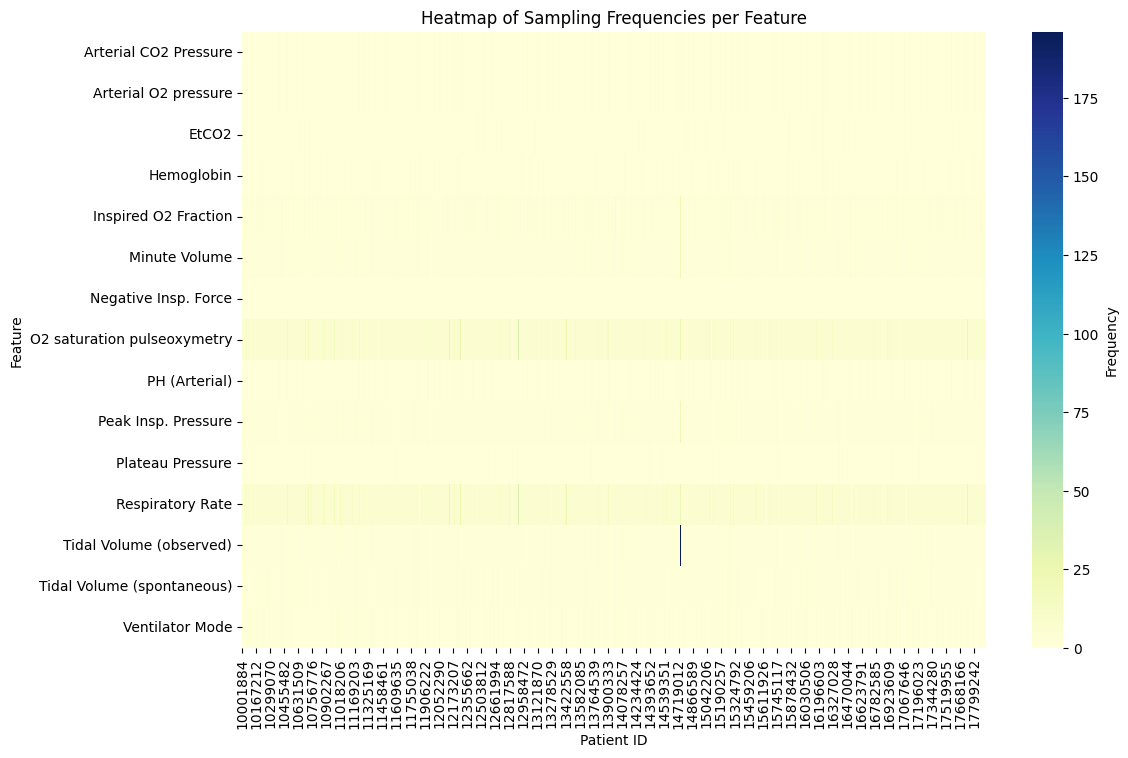

In [ ]:
# Calculate the average sampling frequency per feature and subject
average_frequency_per_patient = per_patient_sampling_frequency_pivot.mean(axis=1)

# Create a heatmap of average sampling frequency per feature
plt.figure(figsize=(12, 8))
sns.heatmap(per_patient_sampling_frequency_pivot.T, cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.title('Heatmap of Sampling Frequencies per Feature')
plt.xlabel('Patient ID')
plt.ylabel('Feature')
plt.show()

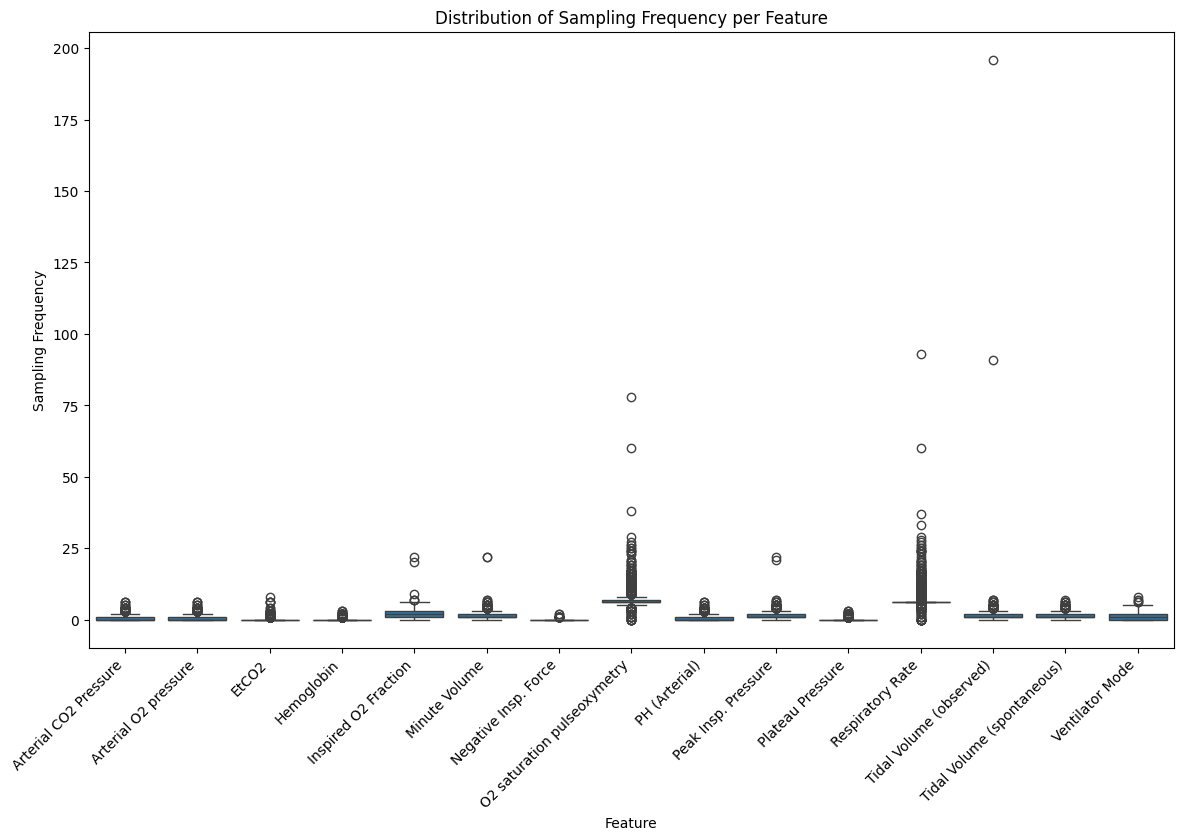

In [ ]:
# Melt the pivoted DataFrame for easier plotting with seaborn
sampling_frequency_melted = per_patient_sampling_frequency_pivot.reset_index().melt(id_vars=['subject_id'], var_name='Feature', value_name='Frequency')

# Plot the distribution of sampling frequencies using a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Feature', y='Frequency', data=sampling_frequency_melted)
plt.title('Distribution of Sampling Frequency per Feature')
plt.xlabel('Feature')
plt.ylabel('Sampling Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

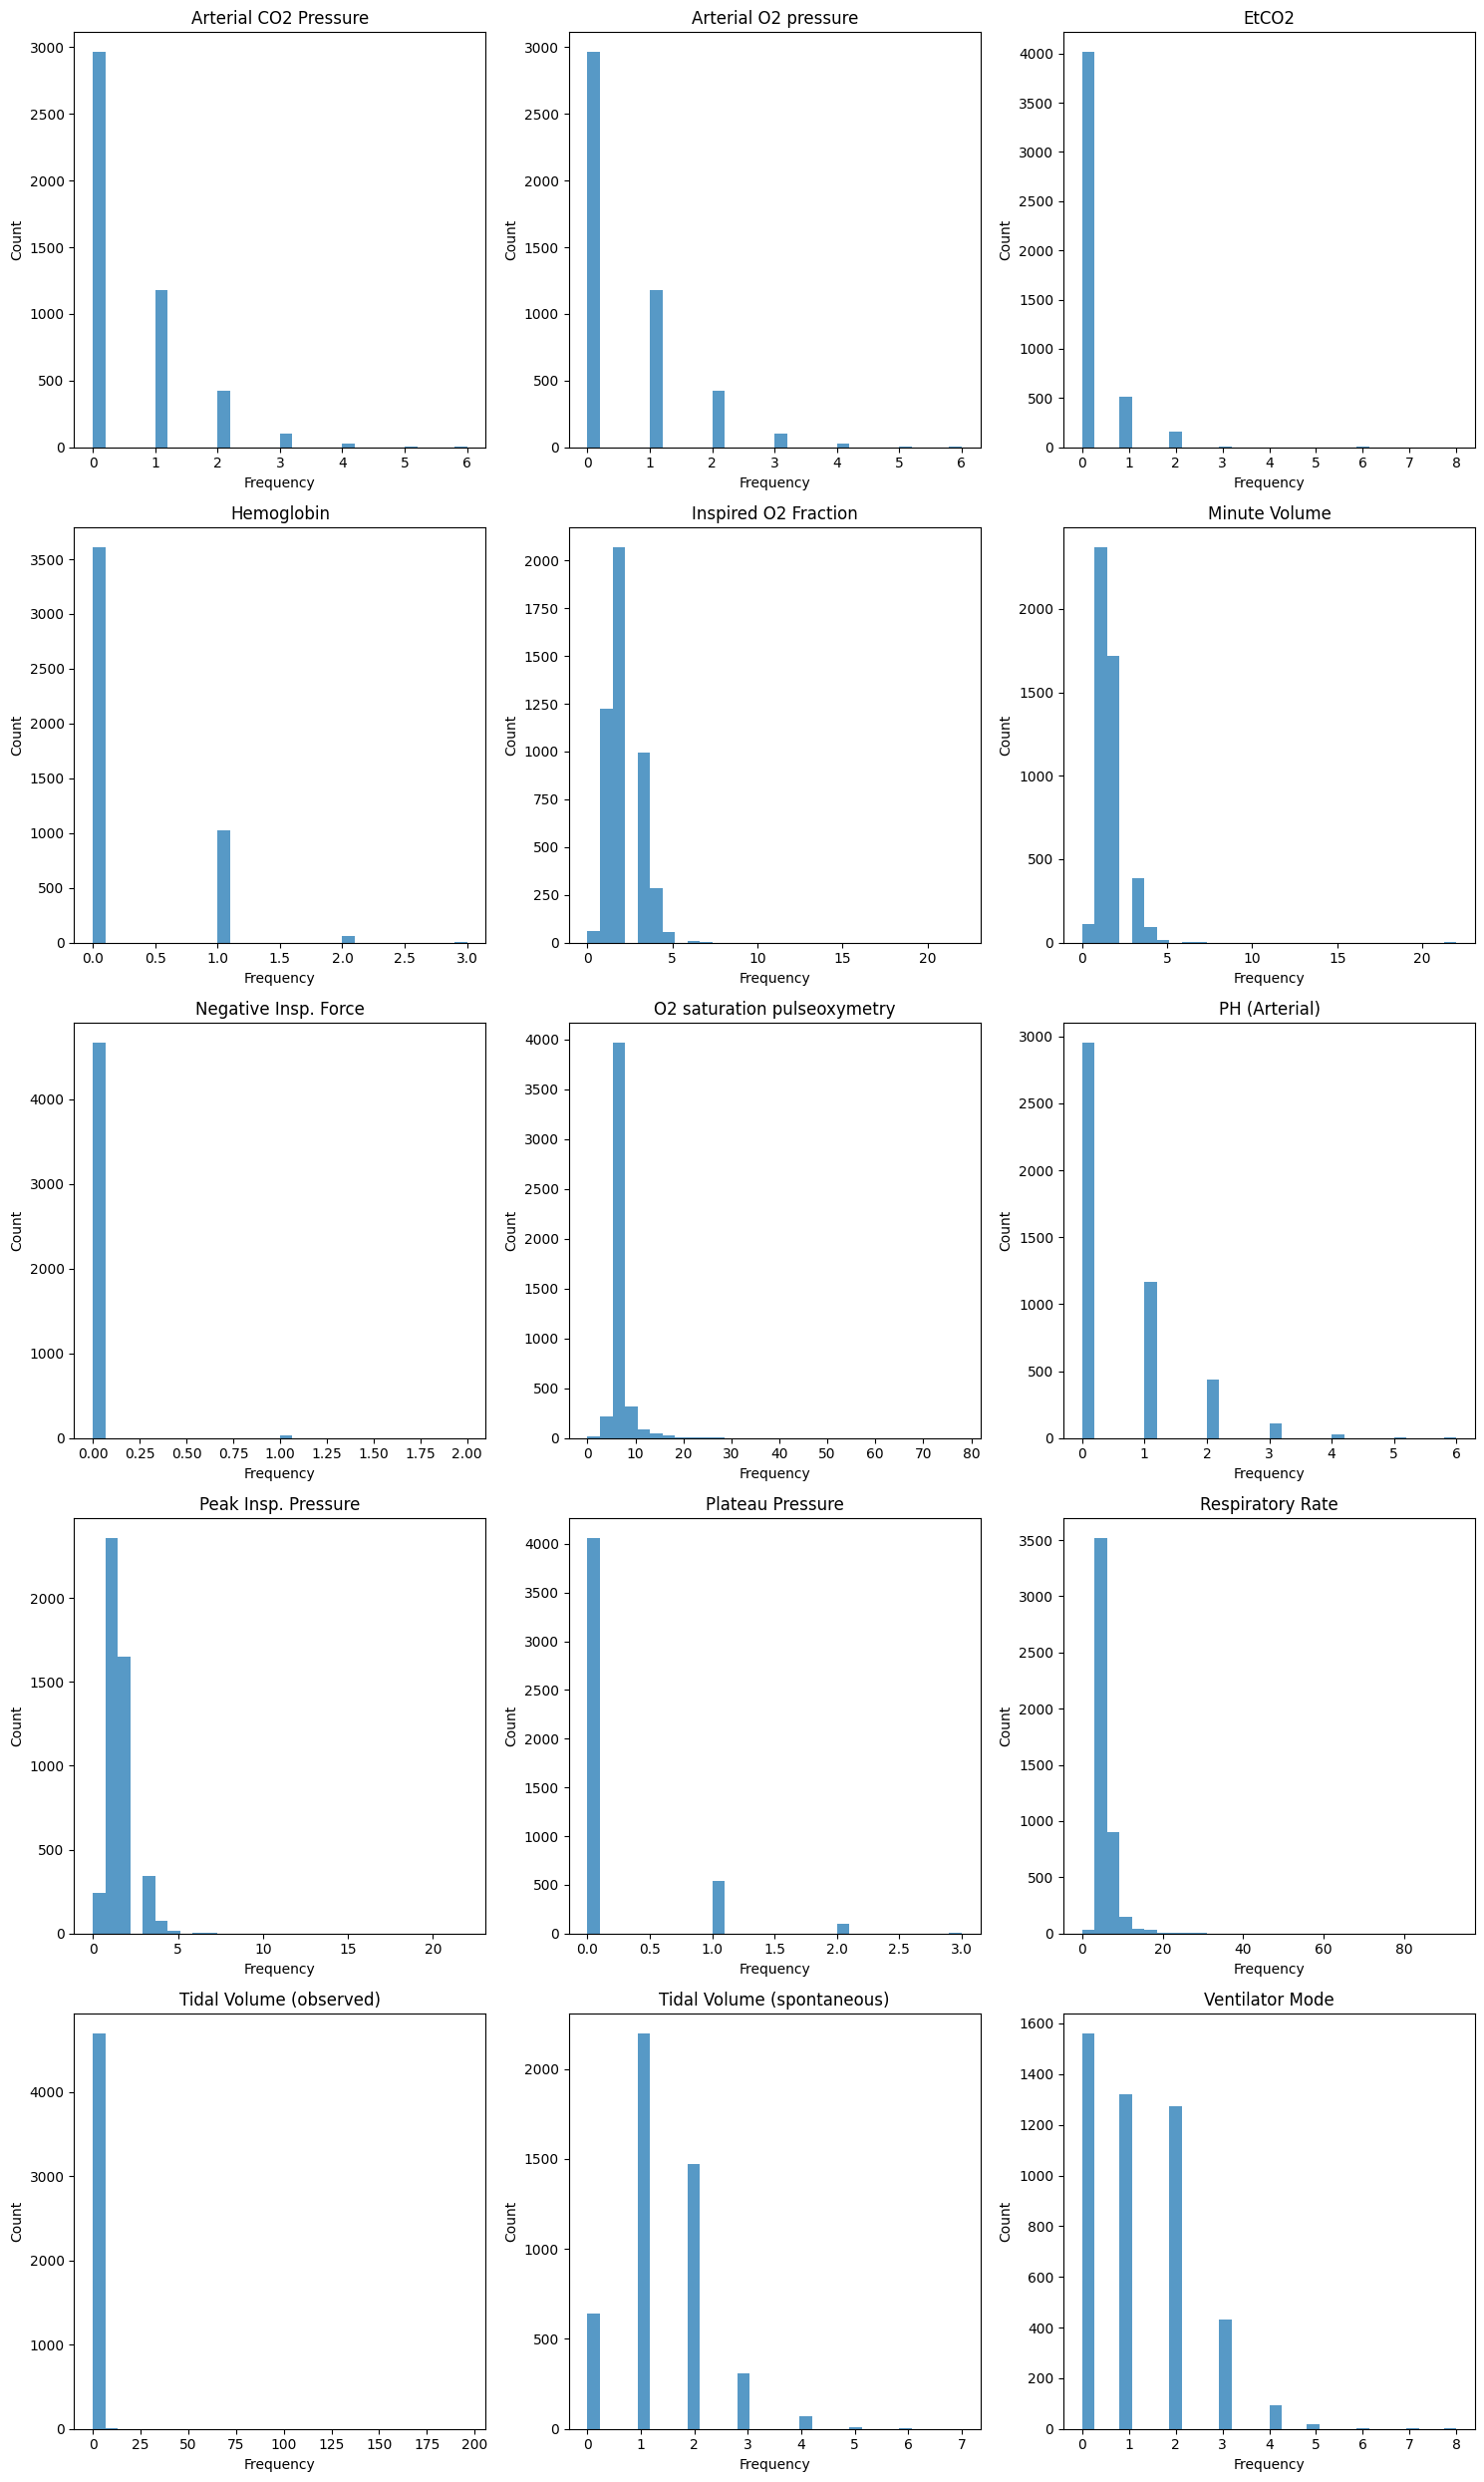

In [ ]:
# Plot histograms of sampling frequencies for each feature
num_features = len(per_patient_sampling_frequency_pivot.columns)
num_cols = 3  # Adjust columns as needed
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(per_patient_sampling_frequency_pivot.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(per_patient_sampling_frequency_pivot[feature], bins=30, alpha=0.75)
    plt.title(feature)
    plt.xlabel('Frequency')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

**05 - Temporal sampling frequency**

Here we can look at the time gap between samples to see the sampling rate.

In [ ]:
features_with_labels_df.head()

subject_id  itemid  valuenum  time_to_extubation_mins  \
0    10001884  223835      40.0                    160.0   
1    10001884  224685     284.0                    160.0   
2    10001884  224686     284.0                    160.0   
3    10001884  224687       6.1                    160.0   
4    10001884  224695      17.0                    160.0   

   time_from_window_start                       label  
0                   200.0        Inspired O2 Fraction  
1                   200.0     Tidal Volume (observed)  
2                   200.0  Tidal Volume (spontaneous)  
3                   200.0               Minute Volume  
4                   200.0         Peak Insp. Pressure

In [ ]:
features_with_labels_temporal_df = features_with_labels_df.copy()
features_with_labels_temporal_df.head()

subject_id  itemid  valuenum  time_to_extubation_mins  \
0    10001884  223835      40.0                    160.0   
1    10001884  224685     284.0                    160.0   
2    10001884  224686     284.0                    160.0   
3    10001884  224687       6.1                    160.0   
4    10001884  224695      17.0                    160.0   

   time_from_window_start                       label  
0                   200.0        Inspired O2 Fraction  
1                   200.0     Tidal Volume (observed)  
2                   200.0  Tidal Volume (spontaneous)  
3                   200.0               Minute Volume  
4                   200.0         Peak Insp. Pressure

In [ ]:
features_with_labels_temporal_df = features_with_labels_temporal_df.sort_values(by=['subject_id', 'label', 'time_from_window_start'])

features_with_labels_temporal_df['time_diff'] = features_with_labels_temporal_df.groupby(['subject_id', 'label'])['time_from_window_start'].diff()
features_with_labels_temporal_df.head()

subject_id  itemid  valuenum  time_to_extubation_mins  \
5    10001884  228640      46.0                    160.0   
0    10001884  223835      40.0                    160.0   
3    10001884  224687       6.1                    160.0   
7    10001884  220277     100.0                    337.0   
9    10001884  220277      99.0                    336.0   

   time_from_window_start                        label  time_diff  
5                   200.0                        EtCO2        NaN  
0                   200.0         Inspired O2 Fraction        NaN  
3                   200.0                Minute Volume        NaN  
7                    23.0  O2 saturation pulseoxymetry        NaN  
9                    24.0  O2 saturation pulseoxymetry        1.0

In [ ]:
# Drop the first row for each group which has NaN time difference
features_with_labels_temporal_df = features_with_labels_temporal_df.dropna(subset=['time_diff'])

# Calculate the average time gap between samples for each feature
average_time_diff = features_with_labels_temporal_df.groupby('label')['time_diff'].mean().sort_values(ascending=False)

# Display the average time differences
print(average_time_diff)

label
Negative Insp. Force           300.000000
Plateau Pressure               188.027523
EtCO2                          174.669951
Peak Insp. Pressure            153.889627
Hemoglobin                     153.565217
Minute Volume                  150.520562
Tidal Volume (spontaneous)     150.291931
Ventilator Mode                145.128225
Inspired O2 Fraction           144.015997
Arterial CO2 Pressure          142.284542
Arterial O2 pressure           142.284542
PH (Arterial)                  140.962042
Tidal Volume (observed)        138.462218
O2 saturation pulseoxymetry     54.120764
Respiratory Rate                54.110068
Name: time_diff, dtype: float64


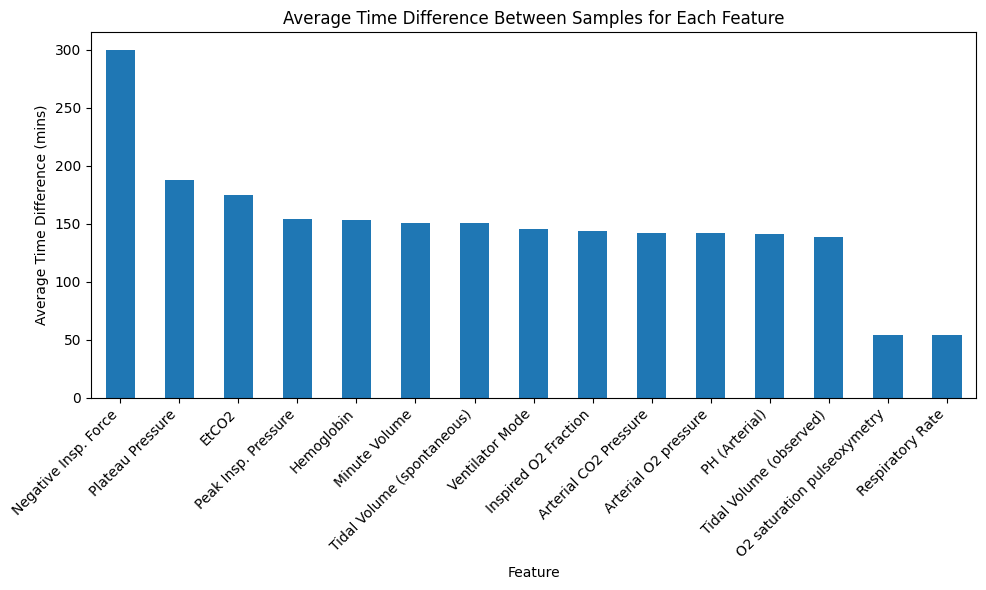

In [ ]:
# Plot the average time difference between samples for each feature
plt.figure(figsize=(10, 6))
average_time_diff.plot(kind='bar')
plt.title('Average Time Difference Between Samples for Each Feature')
plt.xlabel('Feature')
plt.ylabel('Average Time Difference (mins)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Larger time difference means fewer samples taken.

This pattern matches the earlier chart of average sampling frequency in the 6 hours with Respiratory Rate and O2 saturation pulseoxymetry are the most frequently sampled where as Negative Inspiratory Force is the least sampled - seeminly once every 5 hours.

In [ ]:
# Save the table with time series data and labels for later use
features_with_labels_df.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/06_extracted_data_analysis/01_feature_set_1_analysis/patient_f1_data_feature_labels.parquet')